# Python imports

In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 22.4 MB/s 
     |████████████████████████████████| 60.4 MB 50.9 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.dom.minidom
import tensorflow as tf
import pandas as pd
import re
import seaborn as sns
#import cv2#

from PIL import Image, ImageShow, ImageDraw, ImageFont
from xml.dom.minidom import parse
from sklearn.metrics import classification_report, roc_curve, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# use the pretrained model vgg16
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision

#from mtcnn import MTCNN

# ETL Pipeline

In [ ]:
# Settings for our files


image_prefix = "im"
image_number_padding = 5
image_format = ".png"

train_labels  = "train_labels.txt"
train_dir     = "train_images/"

test_labels  = "test_labels.txt"
test_dir     = "test_images/"

shuffle_bufsize = 300
batch_size = 8
seed = 42

In [ ]:
# Function to make a list of tuples (image_name, label)
def make_image_label_dataset(
    data_dir,
    labels_file,
    image_prefix="im",
    image_number_padding=5,
    image_format=".png"):
    """ Given image data directory and labels_file
        return a list of tuples (image_path, label)
    """

    images_list  = []
    labels_list = []

    with open(labels_file, "rt") as f:
        lines = f.readlines()
        for line in lines:
            image_number = line.split(":")[0].rjust(image_number_padding, "0")
            image_path = data_dir + image_prefix + image_number + image_format
            label = line.split(":")[1].split("\n")[0]
            images_list.append(image_path)
            labels_list.append(label)

     
    return tf.data.Dataset.from_tensor_slices((images_list, labels_list))

In [ ]:
# Template for all transformation functions!!
def map_function(tensor_image, tensor_label):
    #tensor_image, tensor_label = tensor_element
    print(tensor_image)
    print(tensor_label)
    return tensor_image, tensor_label


In [ ]:
# One-Hot Encoding
def oh_encode(tensor_image, tensor_label):
    oh_encoded_label = [0, 0, 0]
    labels = ["with_mask", "mask_weared_incorrect", "without_mask"]

    for index, value in enumerate(labels):
        if tf.math.equal(tensor_label, value):
            oh_encoded_label[index] = 1
    
    return tensor_image, oh_encoded_label

In [ ]:
# Image data loading
def load_image(tensor_image, tensor_label):
    image_data = tf.io.read_file(tensor_image)
    image_decoded = tf.io.decode_png(image_data, channels=3, dtype=tf.dtypes.uint8)
    return image_decoded, tensor_label

In [ ]:
# Function to preprocess for VGG16 model
def vgg16_preprocess(tensor_image, tensor_label):
    return tf.keras.applications.vgg16.preprocess_input(tensor_image), tensor_label

In [ ]:
# Function to resize the image to VGG input (224 x 224 x 3)
def resize_image(tensor_image, tensor_label):
    image_resized = tf.image.resize(tensor_image, [224, 224], method="bicubic")
    return image_resized, tensor_label

In [ ]:
def is_train(a, b):
    return not is_val(a, b)

def is_val(a, b):
    return a % 5 == 0
    
def remove_index(a, b):
    return b

In [ ]:
# THIS WILL BE THE ENTIRE PIPELINE
val_ds = (
            make_image_label_dataset(
                data_dir=train_dir,
                labels_file=train_labels)
            .shuffle(
                buffer_size=shuffle_bufsize,
                seed=seed,
                reshuffle_each_iteration=False
            )
            .map(oh_encode)
            .map(load_image)
            .map(resize_image)
            .map(vgg16_preprocess)
            .enumerate()
            .filter(is_val)
            .map(remove_index)
            .batch(batch_size=batch_size, drop_remainder=True)
)

train_ds = (
            make_image_label_dataset(
                data_dir=train_dir,
                labels_file=train_labels)
            .shuffle(
                buffer_size=shuffle_bufsize,
                seed=seed,
                reshuffle_each_iteration=False
            )
            .map(oh_encode)
            .map(load_image)
            .map(resize_image)
            .map(vgg16_preprocess)
            .enumerate()
            .filter(is_train)
            .map(remove_index)
            .batch(batch_size=batch_size, drop_remainder=True)
)

test_ds = (
            make_image_label_dataset(
                data_dir=test_dir,
                labels_file=test_labels)
            .shuffle(
                buffer_size=shuffle_bufsize,
                seed=seed,
                reshuffle_each_iteration=False
            )
            .map(oh_encode)
            .map(load_image)
            .map(resize_image)
            .map(vgg16_preprocess)
            .batch(batch_size=batch_size, drop_remainder=True)
)

In [ ]:
train_ds, val_ds, test_ds

(<BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.int32)>)

In [ ]:
count = 0
for _ in train_ds:
    count += 1

train_ds_length = count

In [ ]:
count = 0
for _ in val_ds:
    count += 1

val_ds_length = count

In [ ]:
# This function should deprocess the images
def reverse_vgg_preprocessing(image):
    # 'BGR'->'RGB'
    image = image.numpy()
    image = image[..., ::-1]
    mean = [123.68, 116.779, 103.939]
    
    # Zero-decenter by mean pixel
    image[..., 0] = image[..., 0] + mean[0]
    image[..., 1] = image[..., 1] + mean[1]
    image[..., 2] = image[..., 2] + mean[2]

    return image.astype(np.uint8)

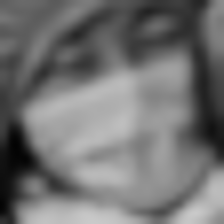

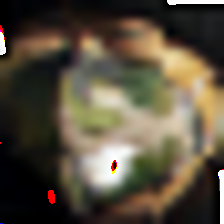

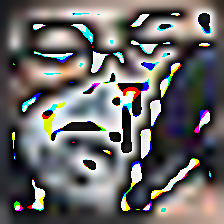

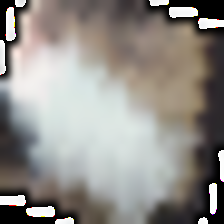

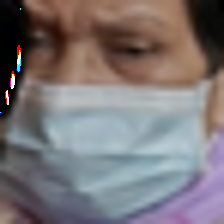

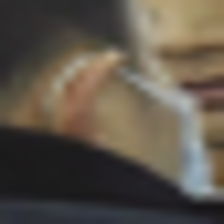

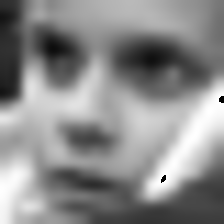

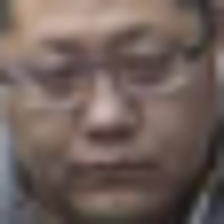

In [ ]:
# ITEM STATUS
for batch in train_ds.take(1):
    #print(batch)
    for item in batch[0]:
        img = reverse_vgg_preprocessing(item)
        #img = item[0].numpy()
        #print(img)
        image = Image.fromarray(img)
        image.show()

# Modeling

In [ ]:
model2 = tf.keras.models.load_model("model2.h5")

In [ ]:
# load pretrained model without classifier layers
model0 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# set the layers of the pretrained model to not trainable!!!
for layer in model0.layers:
	layer.trainable = False

# add new classifier layers
# here we can define at which layer of the pretrained model we attach our layers
cnn = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(model0.layers[-2].output)
pool1 = MaxPool2D(pool_size=(2,2))(cnn)
flat1 = Flatten()(pool1)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1) # triple class classification

# define new model
model2 = Model(inputs=model0.inputs, outputs=output)

# summarize
model2.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# compile the model

opt = Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss=categorical_crossentropy, \
               metrics=[CategoricalAccuracy(), Precision(), 'AUC'])

In [ ]:
# fit the model

epochs=10
batch_size=8
val_batch_size = 8

hist2 = model2.fit(
                    train_ds.repeat(),
                    epochs=epochs,
                    verbose=1,
                    steps_per_epoch=(train_ds_length),
                    callbacks=None,
                    validation_data = val_ds,
                    validation_steps=(val_ds_length),
                    workers=1,
                    use_multiprocessing=True)

model2.save("model2.h5")

Epoch 1/10
1635/1635 [==============================] - 232s 141ms/step - loss: 0.1846 - categorical_accuracy: 0.9492 - precision: 0.9531 - auc: 0.9905 - val_loss: 0.3487 - val_categorical_accuracy: 0.9200 - val_precision: 0.9217 - val_auc: 0.9798
Epoch 2/10
1635/1635 [==============================] - 232s 142ms/step - loss: 0.1712 - categorical_accuracy: 0.9543 - precision: 0.9576 - auc: 0.9917 - val_loss: 0.4569 - val_categorical_accuracy: 0.9289 - val_precision: 0.9310 - val_auc: 0.9767
Epoch 3/10
1635/1635 [==============================] - 232s 142ms/step - loss: 0.1482 - categorical_accuracy: 0.9635 - precision: 0.9659 - auc: 0.9935 - val_loss: 0.5834 - val_categorical_accuracy: 0.9277 - val_precision: 0.9301 - val_auc: 0.9728
Epoch 4/10
1635/1635 [==============================] - 231s 142ms/step - loss: 0.1117 - categorical_accuracy: 0.9730 - precision: 0.9742 - auc: 0.9959 - val_loss: 0.7059 - val_categorical_accuracy: 0.9145 - val_precision: 0.9145 - val_auc: 0.9659
Epoch 5/

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def get_layer_config(model, layer_name):
    inspect_layer = model.get_layer(layer_name)
    inspect_config = inspect_layer.get_config()
    return inspect_config

In [ ]:
inspect_config = print_layer_config(model2, "block1_conv1")
print(inspect_config)

{'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
None


In [ ]:
train_ds_length # this is equal to the (n_images // batch_size)

1635

In [ ]:
model2.evaluate(test_ds)

85/85 [==============================] - 15s 116ms/step - loss: 0.5793 - categorical_accuracy: 0.9779 - precision: 0.9779 - auc: 0.9874


[0.5792603492736816,
 0.9779411554336548,
 0.9778761267662048,
 0.9874280691146851]

In [ ]:
yhat = model2.predict(test_ds)

In [ ]:
yhat[0:15]

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.66323355e-10, 4.22562709e-19],
       [6.64767949e-03, 7.02339037e-07, 9.93351638e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.25311948e-29, 0.00000000e+00],
       [7.09050255e-21, 1.04410627e-19, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.23928581e-29, 1.00160805e-36],
       [9.99999881e-01, 1.24599220e-08, 6.79238141e-08],
       [1.00000000e+00, 2.03584723e-20, 1.20635876e-23],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.50786487e-29, 1.19566114e-38],
       [1.00000000e+00, 4.36809741e-14, 1.33972472e-17],
       [1.00000000e+00, 2.84806125e-30, 2.79256637e-25]], dtype=float32)

In [ ]:
simple_hat = (yhat > 0.5).astype(int)

In [ ]:
simple_hat[0:15]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [ ]:
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    # images = []
    labels = []

    # Iterate over a dataset
    for index, batch in enumerate(ds.as_numpy_iterator()):
        # print(batch[1])
        for index, label in enumerate(batch[1]):
            labels.append(label)
    
    return np.array(labels)

In [ ]:
y_true = dataset_to_numpy(test_ds)

In [ ]:
y_true.shape

(680, 3)

In [ ]:
simple_hat.shape

(680, 3)

In [ ]:
labels_list = ["with mask", "incorrect wearing", "without mask"]

In [ ]:
print(classification_report(y_true, simple_hat, labels=[x for x in range(3)], target_names=labels_list, digits=2))

                   precision    recall  f1-score   support

        with mask       0.99      0.99      0.99       543
incorrect wearing       0.78      0.74      0.76        19
     without mask       0.96      0.96      0.96       118

        micro avg       0.98      0.97      0.98       680
        macro avg       0.91      0.89      0.90       680
     weighted avg       0.98      0.97      0.98       680
      samples avg       0.97      0.97      0.97       680

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_roc_curve(axes,fpr,tpr,title): 
  axes.plot(fpr,tpr) 
  #plt.axis([0,1,0,1]) 
  axes.set_xlabel('False Positive Rate') 
  axes.set_ylabel('True Positive Rate')
  axes.set_title(title)
  axes.plot([0, 1], [0, 1], "r--");  # the random benchmark we need to add manually      

In [ ]:
# get the best threshold for the NN model
def best_threshold(tpr, fpr, thresholds, title):
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold for class [{title}]= %f' % (best_thresh))
    return ix

In [ ]:
def cutoff_plot(tpr, fpr, ix, title):
    plt.plot(tpr)
    plt.plot(fpr, color="red")
    plt.plot([ix, ix], [0, 1], "k--")
    plt.title(title)
    plt.show()

In [ ]:
# fpr = False Positive rate
# tpr = True Positive rate

def calculate_best_thresholds():

    cutoffs = []

    fig, axs = plt.subplots(nrows=1, ncols=len(labels_list), figsize=(len(labels_list)*5, 6))

    for label in labels_list:
        index = labels_list.index(label)
    
        fpr, tpr, thresholds = roc_curve(y_true[:,index] , yhat[:,index])
        ix = best_threshold(tpr, fpr, thresholds, labels_list[index])

        cutoffs.append(thresholds[ix])
        plot_roc_curve(axs[index],fpr,tpr,f"ROC: {labels_list[index]}")


    return cutoffs

Best Threshold for class [with mask]= 0.999777
Best Threshold for class [incorrect wearing]= 0.477602
Best Threshold for class [without mask]= 0.000016


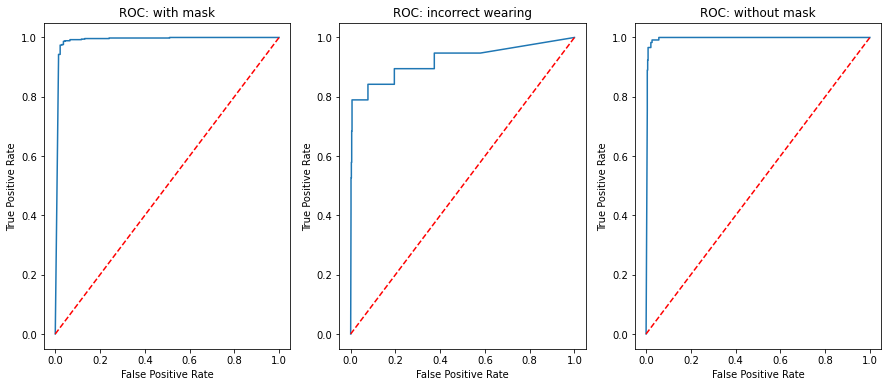

In [ ]:
cutoffs = calculate_best_thresholds()

In [ ]:
yhat_best = yhat.copy()

In [ ]:
for index in range(len(labels_list)):
    yhat_best[:,index] = yhat_best[:,index] > cutoffs[index]

In [ ]:
yhat_best[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
print(classification_report(y_true, yhat_best, labels=[x for x in range(len(labels_list))], target_names=labels_list, digits=2, zero_division=0))

                   precision    recall  f1-score   support

        with mask       0.99      0.97      0.98       543
incorrect wearing       0.78      0.74      0.76        19
     without mask       0.89      0.98      0.93       118

        micro avg       0.97      0.97      0.97       680
        macro avg       0.89      0.90      0.89       680
     weighted avg       0.97      0.97      0.97       680
      samples avg       0.97      0.97      0.97       680



In [ ]:
cms_simple = multilabel_confusion_matrix(y_true, simple_hat)

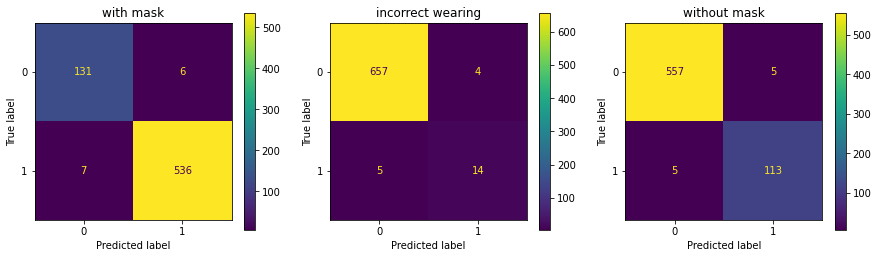

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(3*5, 4))

for index, cm in enumerate(cms_simple):
    ConfusionMatrixDisplay(cm).plot(ax=axs[index])
    axs[index].set_title(labels_list[index])

plt.show()

In [ ]:
cms = multilabel_confusion_matrix(y_true, yhat_best)

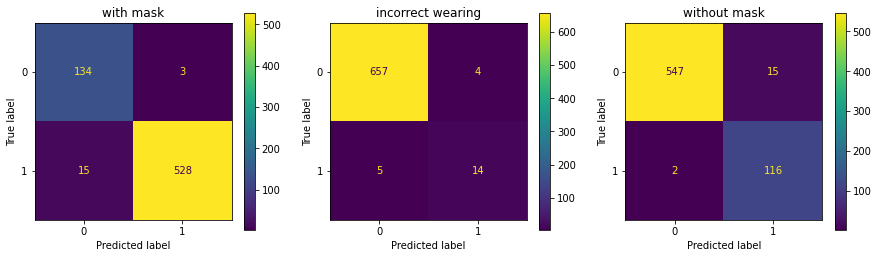

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(3*5, 4))

for index, cm in enumerate(cms):
    ConfusionMatrixDisplay(cm).plot(ax=axs[index])
    axs[index].set_title(labels_list[index])

plt.show()

In [ ]:
for index in range(len(labels_list)):
    acc_score = accuracy_score(y_true[:,index], simple_hat[:,index])
    print(f"Accuracy [{labels_list[index]}] = {acc_score:.2%}")

Accuracy [with mask] = 98.09%
Accuracy [incorrect wearing] = 98.68%
Accuracy [without mask] = 98.53%


In [ ]:
for index in range(len(labels_list)):
    acc_score = accuracy_score(y_true[:,index], yhat_best[:,index])
    print(f"Accuracy [{labels_list[index]}] = {acc_score:.2%}")

Accuracy [with mask] = 97.35%
Accuracy [incorrect wearing] = 98.68%
Accuracy [without mask] = 97.50%


# Any image prediction

In [ ]:
cutoffs

[0.99977654, 0.47760242, 1.6271206e-05]

In [ ]:
face_detector = MTCNN()
#cutoffs = [0.999777, 0.477576, 0.000016]
cutoffs_simple = [0.5, 0.5, 0.5]
labels_list = ["with mask", "incorrect wearing", "without mask"]

In [ ]:
def predict_masks(image_file, face_detector, model, labels_list, cutoffs):

    img_data = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    faces_json = face_detector.detect_faces(img_data)

    boxes = []

    for face in faces_json:
        boxes.append(face["box"])

    print(f"Found {len(boxes)} face(s) in {image_file}.")

    """ Display given image file and all face boxes
    """
    
    font = ImageFont.truetype("ArialCE.ttf", 7)

    with open(image_file, "rb") as f:
        image = Image.open(f)
        
        for i, coords in enumerate(boxes):
            x = coords[0]
            y = coords[1]
            width = coords[2]
            height = coords[3]

            # Now we'll draw the regions on the image
            image_draw = ImageDraw.Draw(image)
            image_draw.rectangle([(x, y), (x+width, y+height)], outline="red")

            face_img = image.crop((x, y, x+width, y+height))
            face_img = face_img.resize((224,224))
            #face_img.show()

            face_data = np.asarray(face_img)
            # print(face_data.shape)
            face_data = tf.keras.applications.vgg16.preprocess_input(face_data)

            face_data = face_data.reshape(1, 224, 224, 3)

            face_yhat = model.predict(face_data)

            face_result = ""

            for index in range(len(labels_list)):
                face_yhat[0,index] = face_yhat[0,index] > cutoffs[index]
                if face_yhat[0,index]==1:
                    face_result = face_result + labels_list[index]

            #print(face_yhat)
            print(f"Face {i}: {face_result}")

            image_draw.text((x, y), str(i)+ ": " + face_result, align ="left")
        
        image.show()

Found 53 face(s) in mosaic.jpg.
Face 0: with mask
Face 1: with mask
Face 2: with mask
Face 3: with mask
Face 4: incorrect wearing
Face 5: with mask
Face 6: with mask
Face 7: with mask
Face 8: with mask
Face 9: with mask
Face 10: with mask
Face 11: with mask
Face 12: with mask
Face 13: with mask
Face 14: with mask
Face 15: with mask
Face 16: with mask
Face 17: incorrect wearing
Face 18: with mask
Face 19: with mask
Face 20: with mask
Face 21: with mask
Face 22: with mask
Face 23: with mask
Face 24: with mask
Face 25: with mask
Face 26: with mask
Face 27: with mask
Face 28: with mask
Face 29: with mask
Face 30: with mask
Face 31: with mask
Face 32: with mask
Face 33: with mask
Face 34: with mask
Face 35: with mask
Face 36: with mask
Face 37: with mask
Face 38: with mask
Face 39: incorrect wearing
Face 40: with mask
Face 41: with mask
Face 42: with mask
Face 43: with mask
Face 44: with mask
Face 45: incorrect wearing
Face 46: with mask
Face 47: without mask
Face 48: incorrect wearing
Face

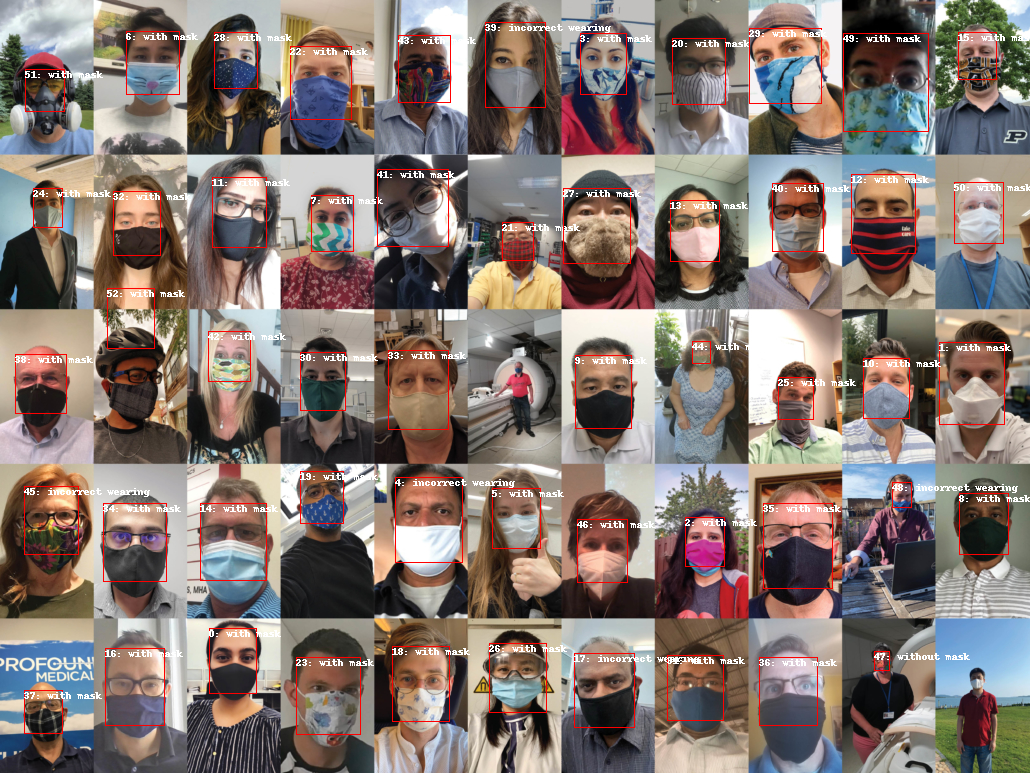

In [ ]:
predict_masks("mosaic.jpg", face_detector, model2, labels_list, cutoffs_simple)

Found 14 face(s) in street.jpeg.
Face 0: without mask
Face 1: without mask
Face 2: without mask
Face 3: without mask
Face 4: without mask
Face 5: without mask
Face 6: with mask
Face 7: with mask
Face 8: without mask
Face 9: incorrect wearing
Face 10: without mask
Face 11: incorrect wearing
Face 12: with mask
Face 13: with mask


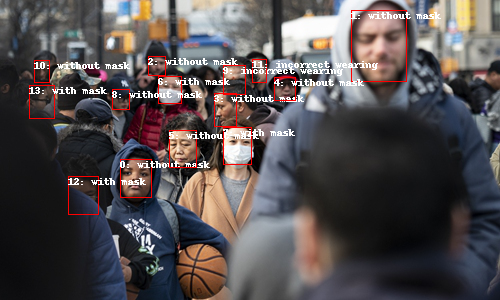

In [ ]:
predict_masks("street.jpeg", face_detector, model2, labels_list, cutoffs_simple)

Found 11 face(s) in mosaic2.jpg.
Face 0: without mask
Face 1: incorrect wearing
Face 2: without mask
Face 3: without mask
Face 4: without mask
Face 5: with mask
Face 6: incorrect wearing
Face 7: with mask
Face 8: without mask
Face 9: with mask
Face 10: without mask


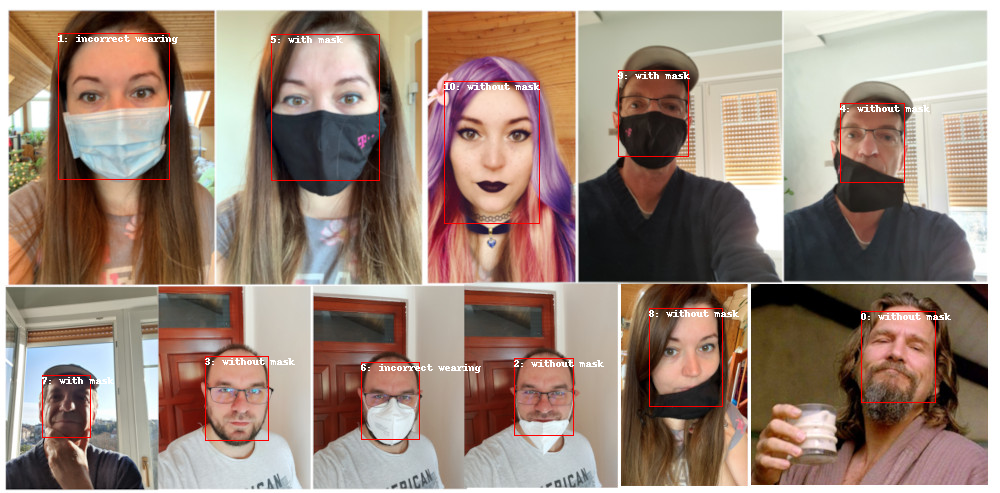

In [ ]:
predict_masks("mosaic2.jpg", face_detector, model2, labels_list, cutoffs_simple)

Found 14 face(s) in Webex.jpg.
Face 0: without mask
Face 1: without mask
Face 2: without mask
Face 3: without mask
Face 4: without mask
Face 5: without mask
Face 6: without mask
Face 7: without mask
Face 8: without mask
Face 9: without mask
Face 10: without mask
Face 11: without mask
Face 12: without mask
Face 13: without mask


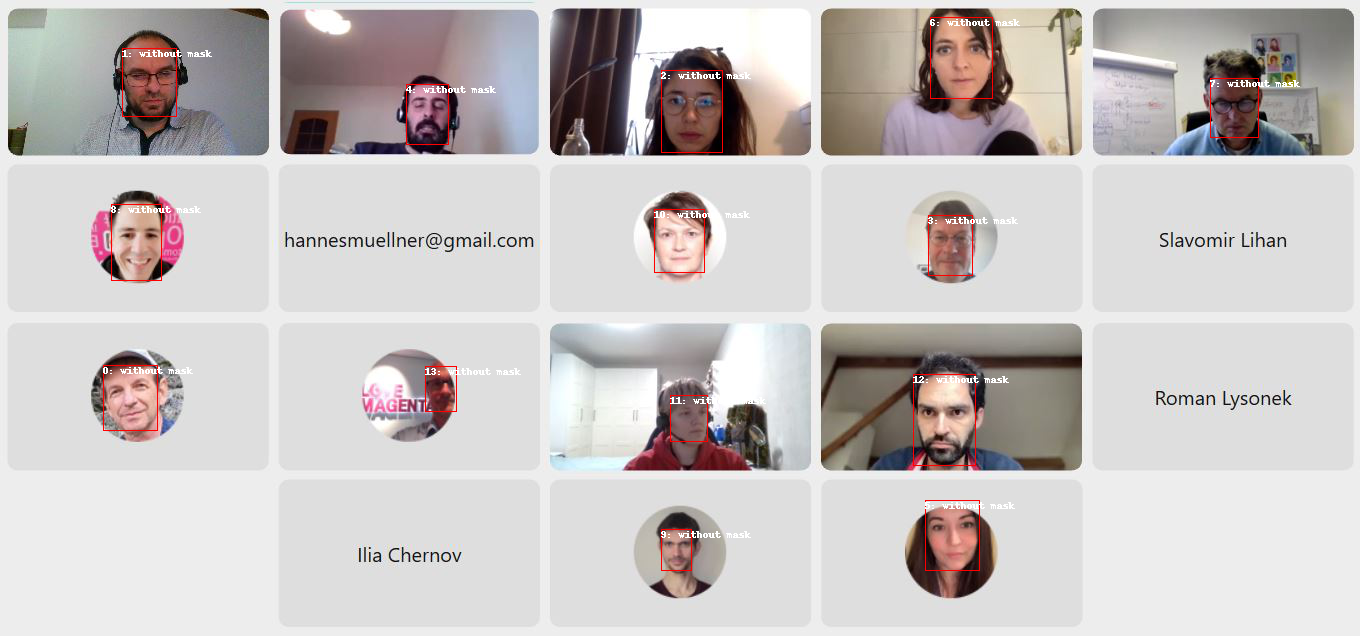

In [ ]:
predict_masks("Webex.jpg", face_detector, model2, labels_list, cutoffs_simple)

Found 2 face(s) in 08physed-exercise-videoSixteenByNineJumbo1600.jpg.
Face 0: without mask
Face 1: with mask


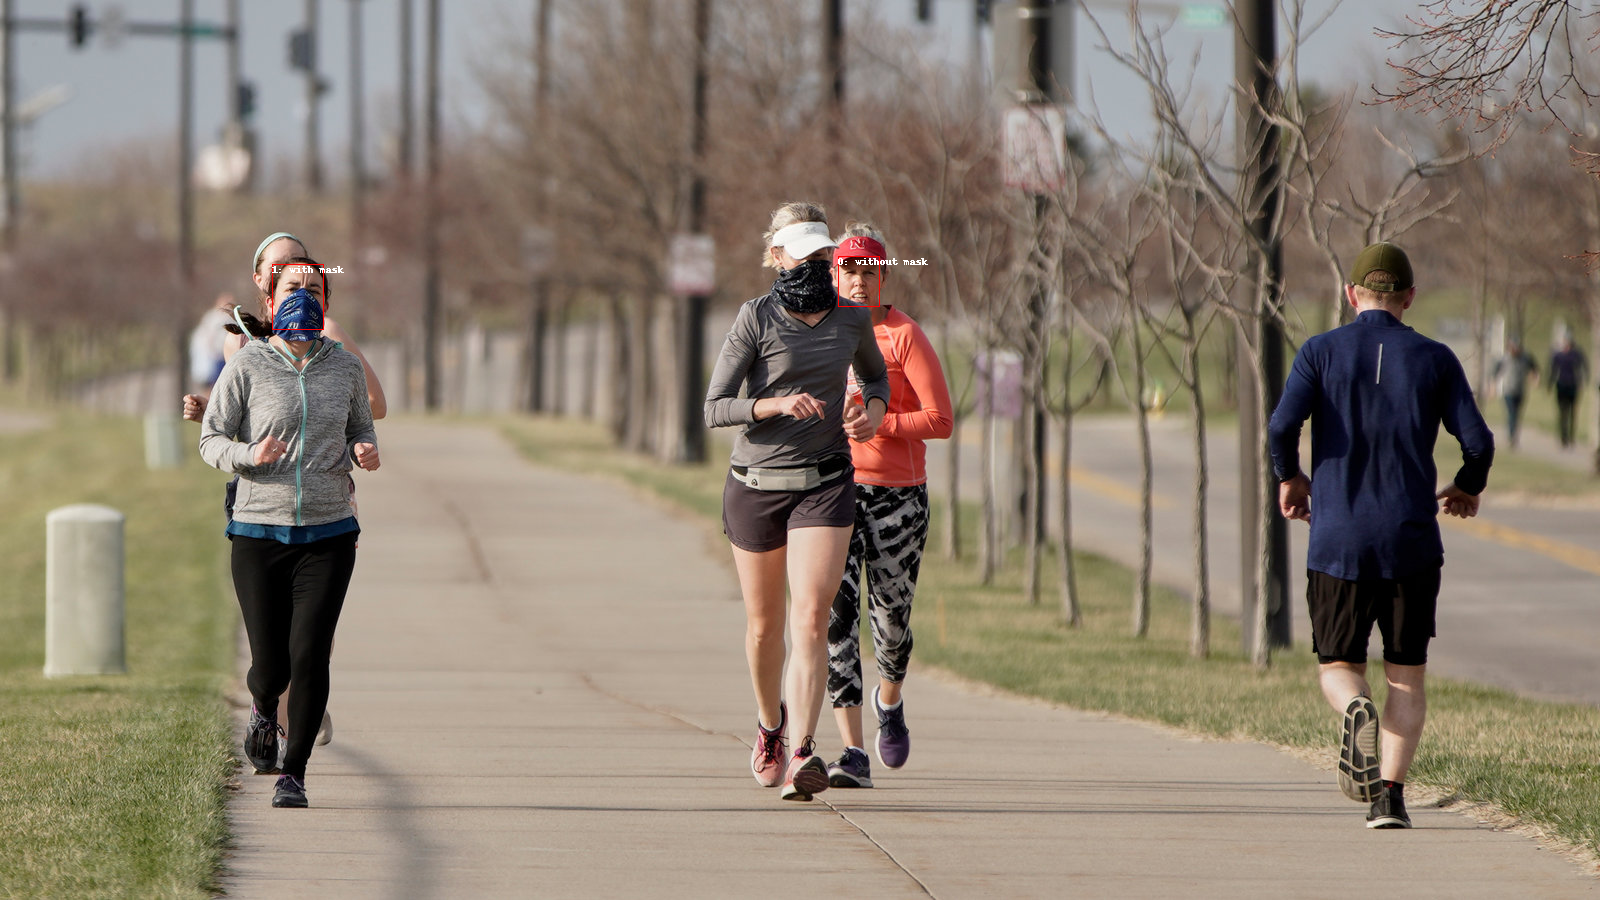

In [ ]:
predict_masks("08physed-exercise-videoSixteenByNineJumbo1600.jpg", face_detector, model2, labels_list, cutoffs_simple)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a109ea11-a7da-42aa-8af0-3a0cdafc917e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>